In [10]:
# --- Imports & run params ---
import json, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Paths
DATA = Path("data")
ART  = Path("artifacts")
FIG  = Path("reports/figures")
for p in [DATA, ART, FIG]:
    p.mkdir(parents=True, exist_ok=True)

# Trading costs (basis points)
FEE_BPS      = 5.0    # per position change (long<->flat)
SLIPPAGE_BPS = 0.0

# Threshold (τ) policy
# If artifacts/threshold.json exists, use it; else default
TAU = 0.50
thr_path = ART / "threshold.json"
if thr_path.exists():
    try:
        t = json.load(open(thr_path, "r", encoding="utf-8"))
        # support either {"LR": {"tau": ...}} or {"threshold": ...}
        if isinstance(t, dict):
            if "LR" in t and isinstance(t["LR"], dict) and "tau" in t["LR"]:
                TAU = float(t["LR"]["tau"])
            elif "threshold" in t:
                TAU = float(t["threshold"])
    except Exception:
        pass

print(f"Using threshold τ = {TAU:.2f} | Fee bps = {FEE_BPS} | Slippage bps = {SLIPPAGE_BPS}")


Using threshold τ = 0.58 | Fee bps = 5.0 | Slippage bps = 0.0


In [11]:
# --- Load Phase-2 dataset and prep features/labels ---
base_csv = DATA / "df_nb02.csv"
assert base_csv.exists(), "Missing data/df_nb02.csv (run Notebook 02 first)"

df = pd.read_csv(base_csv)

# datetime + sort, tz-naive
assert "date" in df.columns, "Expected a 'date' column in df_nb02.csv"
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# label — derive if missing (next-day up)
label_col = next((c for c in ["y","target","label","y_next_up"] if c in df.columns), None)
if label_col is None:
    # derive from next-day ret1 or from close
    if "ret1" in df.columns:
        next_ret = df["ret1"].shift(-1)
    else:
        price_col = next((c for c in ["close","Close","Adj Close","adj_close"] if c in df.columns), None)
        assert price_col is not None, "Need ret1 or a close-like column to derive labels."
        next_ret = df[price_col].pct_change().shift(-1)
    df["y"] = (next_ret > 0).astype(int)
    label_col = "y"

# Features: drop obvious non-features; keep numeric
drop_cols = [label_col, "date", "ticker", "symbol", "spy_close", "vix_close"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).copy().fillna(0.0)
y = df[label_col].astype(int).reset_index(drop=True)

print("Rows/Features:", len(df), "/", X.shape[1])
print("Span:", df["date"].min().date(), "→", df["date"].max().date())
print("Label balance:", float(y.mean()).__round__(3))


Rows/Features: 2685 / 16
Span: 2015-02-06 → 2025-10-09
Label balance: 0.53


In [12]:
# --- Optional: quick leak scan vs next-day real return ---
# This won't drop anything by default; just surfaces suspects.

ret_today = None
if "ret1" in df.columns:
    ret_today = df["ret1"].astype(float)
else:
    price_col = next((c for c in ["close","Close","Adj Close","adj_close"] if c in df.columns), None)
    if price_col is not None:
        ret_today = df[price_col].pct_change().fillna(0.0).astype(float)

if ret_today is not None:
    ret_next = ret_today.shift(-1)
    susp = []
    num = df.select_dtypes(include=[np.number])
    non_feats = {"spy_close","vix_close"}
    for c in num.columns:
        if c in non_feats: 
            continue
        x = pd.to_numeric(num[c], errors="coerce")
        # correlation with next-day actual return
        corr_abs = abs(x.corr(ret_next))
        # AUC vs next-day direction (if numeric is directional)
        auc = np.nan
        try:
            y_next = (ret_next > 0).astype(int)
            mask = x.notna() & y_next.notna()
            if mask.sum() > 10 and y_next[mask].nunique() > 1:
                auc0 = roc_auc_score(y_next[mask], x[mask])
                auc  = max(auc0, 1 - auc0)
        except Exception:
            pass
        susp.append((c, corr_abs, auc))
    susp_df = (pd.DataFrame(susp, columns=["col","|corr(ret+1)|","AUC(dir ret+1)"])
                 .sort_values(["|corr(ret+1)|","AUC(dir ret+1)"], ascending=False)
                 .head(20))
    print("Top-20 potential leaks (FYI only):")
    display(susp_df)
else:
    print("Leak scan skipped (no ret1/close available).")


Top-20 potential leaks (FYI only):


,col,|corr(ret+1)|,AUC(dir ret+1)
16,y,0.690636,1.000000
13,mkt_ret1,0.106168,0.508706
5,ret1,0.057777,0.509576
6,ret5,0.035701,0.500105
14,mkt_ret5,0.033969,0.508030
15,vix_chg1,0.033122,0.504524
7,ret10,0.023735,0.508402
11,macd,0.020985,0.500857
3,close,0.015305,0.500158
1,high,0.014517,0.500440


In [13]:
# --- Build monthly folds: (train_end -> test_month) ---
dts = df["date"]
month = dts.dt.to_period("M")
unique_months = pd.PeriodIndex(month).unique().sort_values()

min_train_months = 12  # at least 1 year of history before first test month
folds = []
for i in range(min_train_months, len(unique_months) - 1):
    train_last = unique_months[i]      # inclusive
    test_m     = unique_months[i + 1]  # next month
    train_idx  = (month <= train_last).values
    test_idx   = (month == test_m).values
    if test_idx.sum() == 0:
        continue
    folds.append((train_idx, test_idx, str(test_m)))

assert len(folds) > 0, "Not enough history to form folds (need >12 months)."
print("Folds:", len(folds), "| first test month:", folds[0][2], "| last:", folds[-1][2])


Folds: 116 | first test month: 2016-03 | last: 2025-10


In [14]:
# --- Rolling refit + predict (per month) ---
probs, trues, dates, month_tag = [], [], [], []

for tr_idx, te_idx, mstr in folds:
    X_tr, X_te = X.loc[tr_idx].values, X.loc[te_idx].values
    y_tr, y_te = y.loc[tr_idx].values, y.loc[te_idx].values

    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None, solver="lbfgs")
    )
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:, 1]

    probs.append(p)
    trues.append(y_te)
    dates.append(df.loc[te_idx, "date"].values)
    month_tag.append(np.array([mstr] * len(y_te)))

# Concatenate into a single walk-forward frame
wf = pd.DataFrame({
    "date":  np.concatenate(dates),
    "y":     np.concatenate(trues).astype(int),
    "prob":  np.concatenate(probs).astype(float),
    "month": np.concatenate(month_tag).astype(str),
}).sort_values("date").reset_index(drop=True)

# Position rule (threshold)
wf["pos"] = (wf["prob"] > TAU).astype(float)

print(wf.shape)
wf.head()


(2418, 5)


,date,y,prob,month,pos
0,2016-03-01,1,0.283122,2016-03,0.0
1,2016-03-02,1,0.490435,2016-03,0.0
2,2016-03-03,1,0.426014,2016-03,0.0
3,2016-03-04,0,0.321528,2016-03,0.0
4,2016-03-07,0,0.478145,2016-03,0.0


In [15]:
# --- Compute realized daily return and strategy equity ---
# Use daily return from df if present, else reconstruct from close
ret_col = next((c for c in ["ret1","daily_ret","r1"] if c in df.columns), None)
if ret_col is None:
    price_col = next((c for c in ["close","Close","Adj Close","adj_close"] if c in df.columns), None)
    assert price_col is not None, "Need ret1 or a close column to compute daily returns."
    px = df[["date", price_col]].dropna().sort_values("date")
    px["ret1"] = px[price_col].pct_change().fillna(0.0)
    ret_series = px.set_index("date")["ret1"]
else:
    ret_series = df.set_index("date")[ret_col].astype(float)

# Map returns to wf rows
wf["ret_mkt"] = wf["date"].map(ret_series).fillna(0.0).values

# Strategy return = position(t-1) * ret_mkt(t) - fees on turnover
wf["pos_prev"] = wf["pos"].shift(1).fillna(0.0)
turnover = (wf["pos"] - wf["pos_prev"]).abs()
fee_rate = (FEE_BPS + SLIPPAGE_BPS) / 1e4
wf["ret_strat"] = wf["pos_prev"] * wf["ret_mkt"] - fee_rate * turnover

# Equity curves
wf["eq_mkt"]   = (1.0 + wf["ret_mkt"]).cumprod()
wf["eq_strat"] = (1.0 + wf["ret_strat"]).cumprod()

print(f"Turnover (avg): {float(turnover.mean()):.4f} | Final equity: {float(wf['eq_strat'].iloc[-1]):.3f}")
wf.tail(3)


Turnover (avg): 0.1100 | Final equity: 0.999


,date,y,prob,month,pos,ret_mkt,pos_prev,ret_strat,eq_mkt,eq_strat
2415,2025-10-07,1,0.463121,2025-10,0.0,-0.000818,0.0,-0.0,11.689993,0.999228
2416,2025-10-08,0,0.468482,2025-10,0.0,0.006160,0.0,0.0,11.762006,0.999228
2417,2025-10-09,0,0.465211,2025-10,0.0,-0.017050,0.0,-0.0,11.561461,0.999228


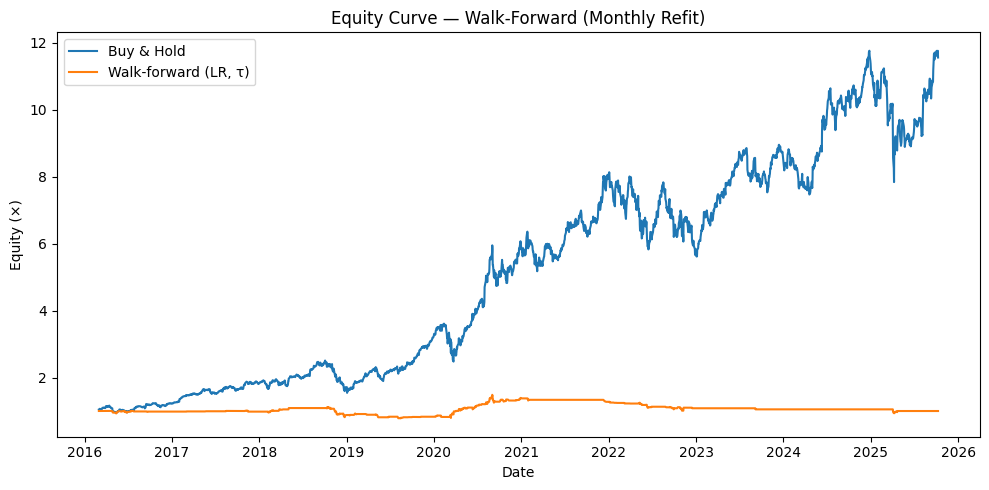

Saved figure: reports\figures\equity_curve_walkforward.png


In [16]:
# --- Plot & save equity curves ---
plt.figure(figsize=(10, 5))
plt.plot(wf["date"], wf["eq_mkt"],  label="Buy & Hold")
plt.plot(wf["date"], wf["eq_strat"], label="Walk-forward (LR, τ)")
plt.title("Equity Curve — Walk-Forward (Monthly Refit)")
plt.xlabel("Date")
plt.ylabel("Equity (×)")
plt.legend()
plt.tight_layout()

out_png = FIG / "equity_curve_walkforward.png"
plt.savefig(out_png, dpi=144)
plt.show()
print("Saved figure:", out_png)


In [17]:
# --- Per-month & overall metrics (robust) ---
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score

def sharpe_annualized(ret, trading_days=252):
    r = pd.Series(ret).dropna()
    if len(r) == 0 or r.std() == 0:
        return np.nan
    return (np.sqrt(trading_days) * r.mean() / r.std())

# Per-month using group key 'month'
per_month = (
    wf.groupby("month", as_index=False)
      .apply(lambda g: pd.Series({
          "AUC": roc_auc_score(g["y"], g["prob"]) if g["y"].nunique() > 1 else np.nan,
          "Sharpe": sharpe_annualized(g["ret_strat"]),
          "TotalReturn": (1.0 + g["ret_strat"]).prod() - 1.0,
          "N": len(g)
      }))
      .reset_index(drop=True)
      .sort_values("month")
)

# Overall block
overall = {
    "CAGR": (wf["eq_strat"].iloc[-1] ** (252 / len(wf)) - 1) if len(wf) else np.nan,
    "Sharpe": sharpe_annualized(wf["ret_strat"]),
    "vol_annual": np.sqrt(252) * wf["ret_strat"].std(),
    "total_return": wf["eq_strat"].iloc[-1] - 1,
    "max_drawdown": ((wf["eq_strat"] / wf["eq_strat"].cummax()) - 1).min(),
}

print("Overall walk-forward:")
print(pd.Series(overall).round(4))

print("\nHead of per-month metrics:")
print(
    per_month.head(10).assign(
        AUC=lambda d: d["AUC"].round(3),
        Sharpe=lambda d: d["Sharpe"].round(2),
        TotalReturn=lambda d: (d["TotalReturn"] * 100).round(2).astype(str) + "%"
    )
)

# Save artifacts
csv_out = DATA / "walkforward_metrics.csv"
per_month.to_csv(csv_out, index=False)
json_out = ART / "walkforward_summary.json"
json.dump({
    "fee_bps": FEE_BPS,
    "slippage_bps": SLIPPAGE_BPS,
    "tau": TAU,
    "overall": {k: (float(v) if pd.notna(v) else None) for k, v in overall.items()},
    "rows": int(len(wf)),
    "start": str(wf["date"].min()),
    "end": str(wf["date"].max())
}, open(json_out, "w"), indent=2)
print("Saved:", csv_out, "|", json_out)


Overall walk-forward:
CAGR           -0.0001
Sharpe          0.0655
vol_annual      0.1328
total_return   -0.0008
max_drawdown   -0.3696
dtype: float64

Head of per-month metrics:
     month    AUC  Sharpe TotalReturn     N
0  2016-03  0.688     NaN        0.0%  22.0
1  2016-04  0.337   -5.17       -4.8%  21.0
2  2016-05  0.773    2.85       3.96%  21.0
3  2016-06  0.583   -0.97      -1.38%  22.0
4  2016-07  0.615    1.54       1.08%  20.0
5  2016-08  0.674     NaN        0.0%  23.0
6  2016-09  0.355   -0.95      -0.43%  21.0
7  2016-10  0.573     NaN        0.0%  21.0
8  2016-11  0.564     NaN        0.0%  21.0
9  2016-12  0.480     NaN        0.0%  21.0
Saved: data\walkforward_metrics.csv | artifacts\walkforward_summary.json


C:\Users\ybh11\AppData\Local\Temp\ipykernel_20140\3542342452.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [18]:
# --- Sanity diagnostics (optional) ---
print("ret_mkt describe:\n", wf["ret_mkt"].describe().to_string(), "\n")
big20 = (wf["ret_mkt"].abs() > 0.20).sum()
big100 = (wf["ret_mkt"].abs() > 1.00).sum()
print(f"Large |ret_mkt| counts:\n> 20%: {big20} | > 100%: {big100}\n")

print("Sample of biggest magnitudes:")
print(wf.loc[wf["ret_mkt"].abs().nlargest(5).index, ["date","ret_mkt","pos","pos_prev"]].sort_values("date"))

# Label alignment check: SAME vs NEXT day
ret_series = wf.set_index("date")["ret_mkt"]
df_tmp = df[["date"]].copy()
df_tmp["ret_mkt"]  = df_tmp["date"].map(ret_series)
df_tmp["ret_next"] = df_tmp["ret_mkt"].shift(-1)
df_tmp["y"] = y.values

same = (df_tmp["y"] == (df_tmp["ret_mkt"] > 0).astype(int)).mean()
nxt  = (df_tmp["y"] == (df_tmp["ret_next"] > 0).astype(int)).mean()
base = (df_tmp["ret_mkt"] > 0).mean()

print("\nLabel alignment:")
print("Match(y, SAME-day up):", round(float(same), 3))
print("Match(y, NEXT-day up):", round(float(nxt), 3))
print("Baseline up-day rate :", round(float(base), 3))


ret_mkt describe:
 count    2418.000000
mean        0.001181
std         0.018373
min        -0.128647
25%        -0.007092
50%         0.001096
75%         0.010134
max         0.153289 

Large |ret_mkt| counts:
> 20%: 0 | > 100%: 0

Sample of biggest magnitudes:
           date   ret_mkt  pos  pos_prev
1016 2020-03-13  0.119808  0.0       1.0
1017 2020-03-16 -0.128647  1.0       0.0
1023 2020-03-24  0.100325  0.0       1.0
1113 2020-07-31  0.104689  0.0       0.0
2291 2025-04-09  0.153289  0.0       0.0

Label alignment:
Match(y, SAME-day up): 0.502
Match(y, NEXT-day up): 0.953
Baseline up-day rate : 0.483
